In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import shap
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import r2_score, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from TreeModelsFromScratch.DecisionTree import DecisionTree
from TreeModelsFromScratch.RandomForest import RandomForest
from TreeModelsFromScratch.SmoothShap import verify_shap_model, smooth_shap, GridSearchCV_scratch, cross_val_score_scratch
from scipy.stats import linregress
import os
from datetime import datetime
import pickle

In [3]:
#load JS vis in the notebook for shap plots
shap.initjs() 

In [4]:
#for storing results
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","titanic")
today_str = datetime.today().strftime("%Y%m%d")

### Load and clean dataset

The datast from OpenML seems to be ordered and does not come with the PassengerId column. Therefore we use the dataset from kaggle.

In [5]:
# # load dataset
# data = fetch_openml('titanic', version=1)["frame"]
# data.drop(['name', 'boat', 'body', 'home.dest', 'cabin', 'embarked', 'sibsp', 'parch', 'ticket', 'fare'], axis=1, inplace=True)
# data = data[data["age"].notnull()] #filter rows which are nan
# data["sex"] = pd.get_dummies(data["sex"])["female"] #dummy code sex (1==Female)
# data= data.sample(frac=1) #shuffle
# data = data.reset_index(drop=True) #to drop old index
# data = data.reset_index() #to create passengerId feature
# data.rename(columns={"index":"pid"}, inplace=True)

In [6]:
# X = data[['age', 'pclass', 'sex', 'pid']]
# y = data["survived"].astype("float")

In [7]:
data = pd.read_csv("../raw_data/titanic/titanic_train.csv")
data = data[data["Age"].notnull()] #filter rows which are nan
data["Sex"] = pd.get_dummies(data["Sex"])["female"] #dummy code sex (1==Female)

In [8]:
X = data[['Age', 'Pclass', 'Sex', 'PassengerId']]
y = data["Survived"].astype("float")

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

### Fit scratch RF model and plot inbag oob SHAP correlation

In [10]:
rf_scr = RandomForest(n_trees= 100, treetype="classification", 
                    oob=True, oob_SHAP=True, random_state=42)

rf_scr.fit(X_train, y_train)

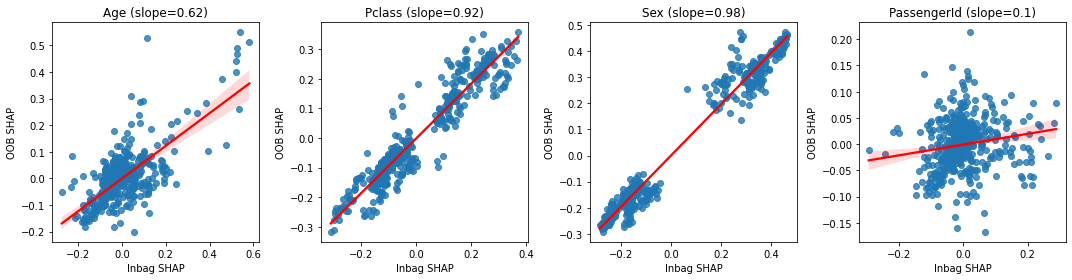

In [11]:
fig, axs = plt.subplots(1,4, figsize=(15,4))

for i in range(4):
    p = sns.regplot(x=rf_scr.inbag_SHAP_values[:, i].reshape(-1, 1), y=rf_scr.oob_SHAP_values[:, i], line_kws={"color": "red"}, ax=axs[i])
    slope, intercept, r_value, p_value, std_err = linregress(x=p.get_lines()[0].get_xdata(),y=p.get_lines()[0].get_ydata())
    axs[i].set_title(f"{rf_scr.feature_names[i]} (slope={round(slope,2)})")# - regression coef: {np.round(rf_scr.smSHAP_coefs[i],2)}")
    axs[i].set_xlabel("Inbag SHAP")
    axs[i].set_ylabel("OOB SHAP")

#plt.setp(axs, xlim=[0, 0.5], ylim=[0, 0.5]);
plt.tight_layout();

#### Comparison of SHAP values for scratch RF

In [12]:
export_model_rf = rf_scr.export_forest_for_SHAP()

#import model into shap tree explainer
explainer_rf = shap.TreeExplainer(export_model_rf)

# Compute shap scores of RF for train data
shap_vals_rf_raw = explainer_rf.shap_values(X_train, y_train)

In [13]:
smooth_shap_vals, mean_smooth_shap, lin_coefs = smooth_shap(rf_scr.inbag_SHAP_values, rf_scr.oob_SHAP_values)

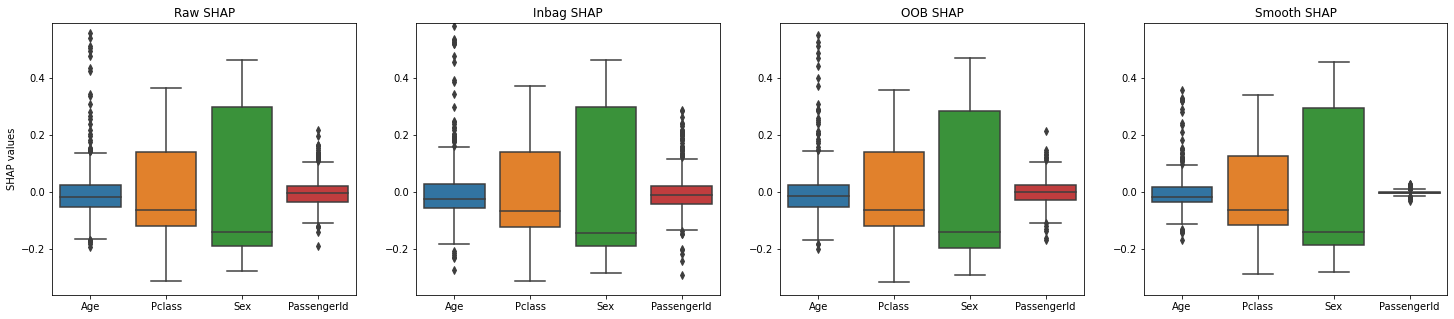

In [14]:
# Comparison of Shap value distribution p feature
fig, axs = plt.subplots(1,4,figsize=(25,5))


sns.boxplot(data=shap_vals_rf_raw, ax =axs[0])
sns.boxplot(data=rf_scr.inbag_SHAP_values, ax=axs[1])
sns.boxplot(data=rf_scr.oob_SHAP_values, ax=axs[2])
sns.boxplot(data=smooth_shap_vals, ax =axs[3])


axs[0].set_title("Raw SHAP")
axs[1].set_title("Inbag SHAP")
axs[2].set_title("OOB SHAP")
axs[3].set_title("Smooth SHAP")
axs[0].set_ylabel("SHAP values")

plt.setp(axs, xticks=[0, 1, 2, 3], xticklabels=X_train.columns);

plt.setp(axs, ylim=axs[2].get_ylim());

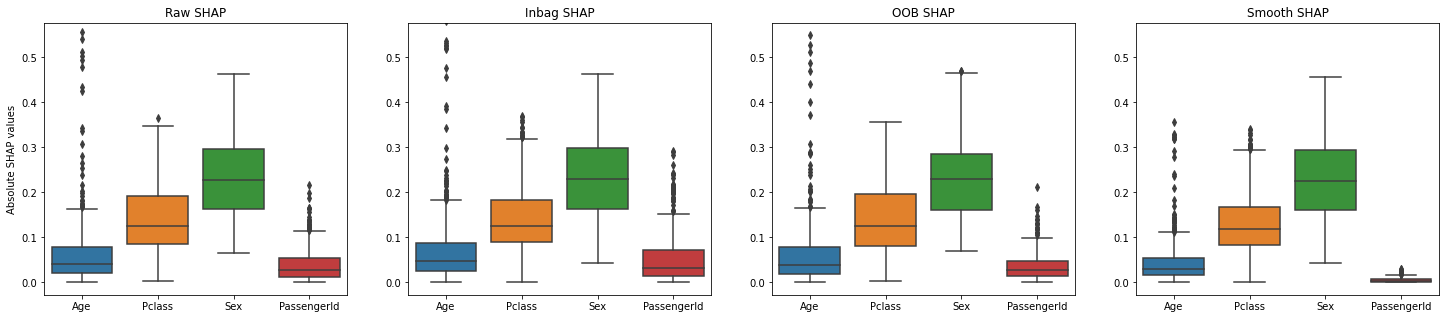

In [15]:
# Comparison of absolute value distribution p feature
fig, axs = plt.subplots(1,4,figsize=(25,5))


sns.boxplot(data=np.abs(shap_vals_rf_raw), ax =axs[0])
sns.boxplot(data=np.abs(rf_scr.inbag_SHAP_values), ax=axs[1])
sns.boxplot(data=np.abs(rf_scr.oob_SHAP_values), ax=axs[2])
sns.boxplot(data=np.abs(smooth_shap_vals), ax =axs[3])


axs[0].set_title("Raw SHAP")
axs[1].set_title("Inbag SHAP")
axs[2].set_title("OOB SHAP")
axs[3].set_title("Smooth SHAP")
axs[0].set_ylabel("Absolute SHAP values")

plt.setp(axs, xticks=[0, 1, 2, 3], xticklabels=X_train.columns);

plt.setp(axs, ylim=axs[2].get_ylim());

#### Comparison of raw SHAP values for RF, hsRF & hsRF with Smooth SHAP

In [16]:
def raw_shap_comparison(X_train, X_test, y_train, y_test, n_estimators=100, reg_params=[0.1,1,10,50,100], random_state=None):
    #Fit scratch without HS
    rf_scr = RandomForest(n_trees=n_estimators, treetype='classification', random_state=random_state)
    rf_scr.fit(X_train, y_train)
    y_pred_scratch = rf_scr.predict(X_test)
    print("RF scratch prediction complete")

    #HS scratch
    grid = {"HS_lambda": reg_params}

    rf_scr_HS = RandomForest(n_trees=n_estimators, treetype='classification', 
                            HShrinkage=True, random_state=random_state)
    grid_cv_HS = GridSearchCV_scratch(rf_scr_HS, grid, X_train, y_train, 3, roc_auc_score)
    y_pred_scratch_HS = rf_scr_HS.predict(X_test)
    print("hsRF scratch prediction complete")

    #HS scratch with smooth SHAP
    rf_scr_HSsmSH = RandomForest(n_trees=n_estimators, treetype='classification', oob=True, oob_SHAP=True,
                            HS_smSHAP=True, random_state=random_state)
    grid_cv_HSsmSH = GridSearchCV_scratch(rf_scr_HSsmSH, grid, X_train, y_train, 3, roc_auc_score)
    y_pred_scratch_HSsmSH = rf_scr_HSsmSH.predict(X_test)    
    print("hsRF w. Smooth SHAP scratch prediction complete")

    #AUC scores
    auc_rf_scratch = roc_auc_score(y_test, y_pred_scratch)
    auc_rf_scratch_HS = roc_auc_score(y_test, y_pred_scratch_HS)
    auc_rf_scratch_HSsmSH = roc_auc_score(y_test, y_pred_scratch_HSsmSH)

    #Raw SHAP values
    #RF
    export_model_rf = rf_scr.export_forest_for_SHAP()
    explainer_rf = shap.TreeExplainer(export_model_rf)
    shap_vals_rf_raw = explainer_rf.shap_values(X_train, y_train)

    #hsRF
    export_model_rfHS = rf_scr_HS.export_forest_for_SHAP()
    explainer_rfHS = shap.TreeExplainer(export_model_rfHS)
    shap_vals_rfHS_raw = explainer_rfHS.shap_values(X_train, y_train)    

    #hsRF with smooth SHAP
    export_model_rfHSsmH = rf_scr_HSsmSH.export_forest_for_SHAP()
    explainer_rfHSsmH = shap.TreeExplainer(export_model_rfHSsmH)
    shap_vals_rfHSsmH_raw = explainer_rfHSsmH.shap_values(X_train, y_train)  

    #Create plot
    fig, axs = plt.subplots(1,3,figsize=(20,5))

    sns.boxplot(data=np.abs(shap_vals_rf_raw), ax =axs[0])
    sns.boxplot(data=np.abs(shap_vals_rfHS_raw), ax=axs[1])
    sns.boxplot(data=np.abs(shap_vals_rfHSsmH_raw), ax=axs[2])
    axs[0].set_ylabel("Absolute SHAP values")
    axs[0].set_title(f"RF (AUC {np.round(auc_rf_scratch,3)})")
    axs[1].set_title(f"hsRF (AUC {np.round(auc_rf_scratch_HS,3)})")
    axs[2].set_title(f"hsRF w. Smooth SHAP (AUC {np.round(auc_rf_scratch_HSsmSH,3)})");

    result = {
        "rf_scr":rf_scr_HSsmSH,
        "rf_scr_HS":rf_scr_HS,
        "rf_scr_HSsmSH":rf_scr_HSsmSH,
        "shap_vals_rf_raw":shap_vals_rf_raw,
        "shap_vals_rfHS_raw":shap_vals_rfHS_raw,
        "shap_vals_rfHSsmH_raw":shap_vals_rfHSsmH_raw,
        "explainer_rf":explainer_rf,
        "explainer_rfHS":explainer_rfHS,
        "explainer_rfHSsmH":explainer_rfHSsmH,
        "fig":fig,
        "auc_rf_scratch":auc_rf_scratch,
        "auc_rf_scratch_HS":auc_rf_scratch_HS,
        "auc_rf_scratch_HSsmSH":auc_rf_scratch_HSsmSH,
        "n_estimators":n_estimators,
        "reg_params":reg_params,
        "grid_cv_HS":grid_cv_HS,
        "grid_cv_HSsmSH":grid_cv_HSsmSH,
        "X_train":X_train, 
        "X_test":X_test, 
        "y_train": y_train, 
        "y_test": y_test
    }

    return result

RF scratch prediction complete
hsRF scratch prediction complete
hsRF w. Smooth SHAP scratch prediction complete


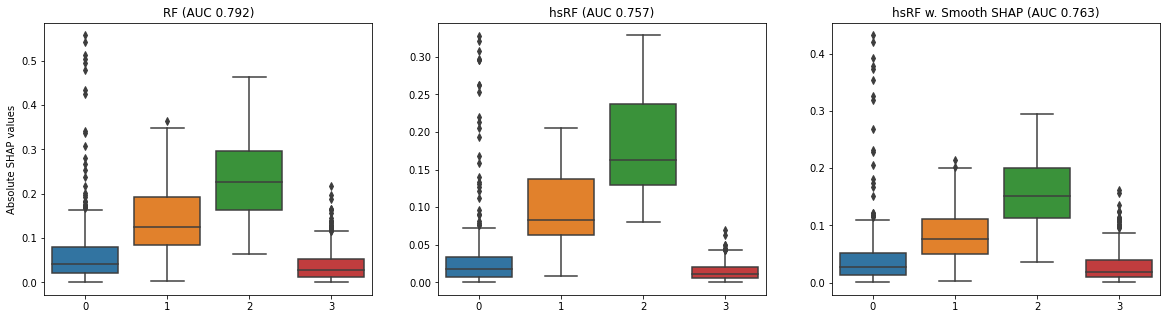

In [17]:
shap_dict = raw_shap_comparison(X_train, X_test, y_train, y_test, n_estimators=100, reg_params=[0.1,1,10,50,100], random_state=42)

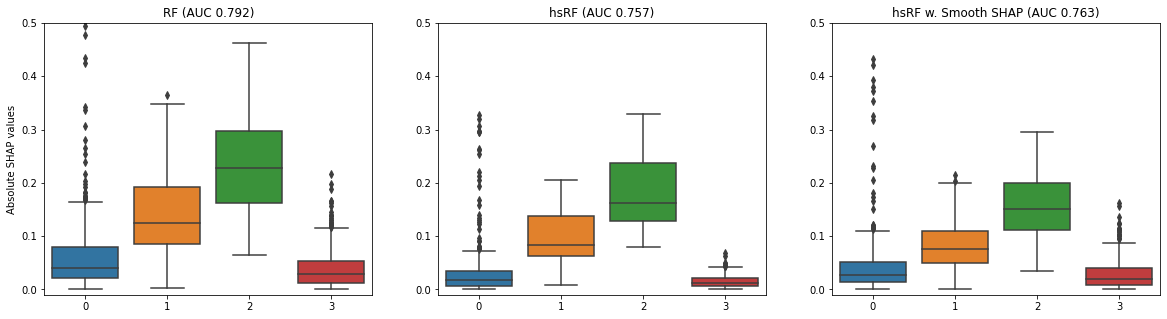

In [114]:
fig = shap_dict.get("fig")
axs = fig.axes
plt.setp(axs, ylim=(-0.01,0.5))
fig

In [18]:
# Save figure and data
shap_dict.get("fig").savefig(f"{data_path}/{today_str}_titanic_raw_shap_vals.png")

# Store results as pickle file
with open(f"{data_path}/{today_str}_titanic_raw_shap_data.pickle", 'wb') as handle:
    pickle.dump(shap_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Beeswarm SHAP plots

In [19]:
#with open(f"{data_path}/20221118_titanic_raw_shap_data.pickle", 'rb') as handle:
#    shap_dict = pickle.load(handle)

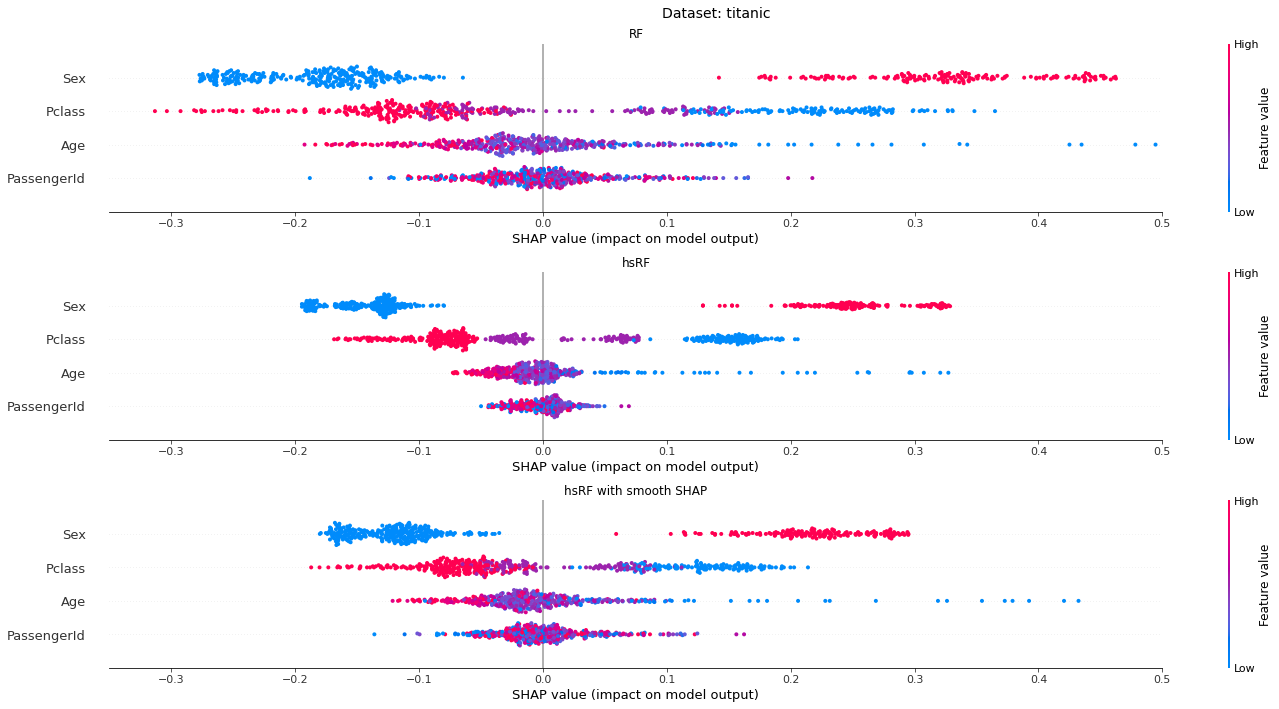

In [20]:
#Create plot
fig = plt.figure()

#RF
ax0 = fig.add_subplot(311)
ax0.set_title("RF")
shap.summary_plot(shap_dict.get("shap_vals_rf_raw"), shap_dict.get("X_train"), shap_dict.get("X_train").columns, show=False)

#hsRF
ax1 = fig.add_subplot(312)
ax1.set_title("hsRF")
shap.summary_plot(shap_dict.get("shap_vals_rfHS_raw"), shap_dict.get("X_train"), shap_dict.get("X_train").columns, show=False)

#hsRF with smooth SHAP
ax2 = fig.add_subplot(313)
ax2.set_title("hsRF with smooth SHAP")
shap.summary_plot(shap_dict.get("shap_vals_rfHSsmH_raw"), shap_dict.get("X_train"), shap_dict.get("X_train").columns, show=False)

plt.gcf().set_size_inches(20,10)
plt.suptitle(f"Dataset: titanic", fontsize=14)
plt.setp([ax0, ax1, ax2], xlim=(-0.35, 0.5))
plt.tight_layout() 
plt.show()

#### SHAP force plot

In [99]:
#RF
shap.force_plot(shap_dict.get("explainer_rf").expected_value, shap_dict.get("shap_vals_rf_raw"), features=X_train)

In [100]:
#hsRF
shap.force_plot(shap_dict.get("explainer_rfHS").expected_value, shap_dict.get("shap_vals_rfHS_raw"), features=X_train)

In [101]:
#hsRF with smooth SHAP
shap.force_plot(shap_dict.get("explainer_rfHSsmH").expected_value, shap_dict.get("shap_vals_rfHSsmH_raw"), features=X_train)

Lets have a look at some local explanations in more detail

In [70]:
df = X_train.reset_index()
df = df[(df["Pclass"]==1)&(df["Sex"]==1)]
idx_max = df[(df["PassengerId"]==df["PassengerId"].max())]["index"]
idx_min = df[(df["PassengerId"]==df["PassengerId"].min())]["index"]

Local explanation for highest pid, for female and pclass 1

In [89]:
#RF
shap.force_plot(shap_dict.get("explainer_rf").expected_value, shap_dict.get("shap_vals_rf_raw")[idx_max.index[0]], features=X_train.loc[idx_max])

In [90]:

# hsRF
shap.force_plot(shap_dict.get("explainer_rfHS").expected_value, shap_dict.get("shap_vals_rfHS_raw")[idx_max.index[0]], features=X_train.loc[idx_max])

In [91]:
# hs RF w Smooth SHAP
shap.force_plot(shap_dict.get("explainer_rfHSsmH").expected_value, shap_dict.get("shap_vals_rfHSsmH_raw")[idx_max.index[0]], features=X_train.loc[idx_max])

Local explanation for lowest pid, for female and pclass 1

In [98]:
#RF
shap.force_plot(shap_dict.get("explainer_rf").expected_value, shap_dict.get("shap_vals_rf_raw")[idx_min.index[0]], features=X_train.loc[idx_min])

In [97]:
# hsRF
shap.force_plot(shap_dict.get("explainer_rfHS").expected_value, shap_dict.get("shap_vals_rfHS_raw")[idx_min.index[0]], features=X_train.loc[idx_min])

In [96]:
# hsRF w wm SHAP
shap.force_plot(shap_dict.get("explainer_rfHSsmH").expected_value, shap_dict.get("shap_vals_rfHSsmH_raw")[idx_min.index[0]], features=X_train.loc[idx_min])

### Decision boundaries

In [8]:
# Functions for plotting dec boundaries of scratch estimators
def make_meshgrid(x, y, hx=.02, hy=0.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [24]:
def create_dec_boun_comparison(X_train, X_test, y_train, y_test, n_estimators=50, reg_params=[0.1,1,10,50,100], random_state=1, 
                                hx=0.02, hy=0.02, idx_feat1=None, idx_feat2=None):

    if (idx_feat1 is None) | (idx_feat2 is None):
    
        #Fit classifier for most imp feats
        rf_scr = RandomForest(n_trees=n_estimators, random_state=random_state)
        rf_scr.fit(X_train, y_train)

        # Get 1st and 2nd most important feature according to MDI
        most_imp_feats = np.argsort(rf_scr.feature_importances_, axis=0)[-2:][::-1]
    else:
        most_imp_feats = [idx_feat1, idx_feat2]
        
    # get feature names
    most_imp_feats_names = [X_train.columns[i] for i in most_imp_feats]

    # Create subset
    X_small = X_train.iloc[:,most_imp_feats].copy()

    #Fit scratch without HS
    rf_scr = RandomForest(n_trees=n_estimators, treetype='classification', random_state=random_state)
    rf_scr.fit(X_small, y_train)
    y_pred_scratch = rf_scr.predict(X_test.iloc[:,most_imp_feats])
    print("RF scratch prediction complete")

    #HS scratch
    grid = {"HS_lambda": reg_params}

    rf_scr_HS = RandomForest(n_trees=n_estimators, treetype='classification', 
                            HShrinkage=True, random_state=random_state)
    grid_cv_HS = GridSearchCV_scratch(rf_scr_HS, grid, X_small, y_train, 3, roc_auc_score)
    y_pred_scratch_HS = rf_scr_HS.predict(X_test.iloc[:,most_imp_feats])
    print("hsRF scratch prediction complete")

    #HS scratch with smooth SHAP
    rf_scr_HSsmSH = RandomForest(n_trees=n_estimators, treetype='classification', oob=True, oob_SHAP=True,
                            HS_smSHAP=True, random_state=random_state)
    grid_cv_HSsmSH = GridSearchCV_scratch(rf_scr_HSsmSH, grid, X_small, y_train, 3, roc_auc_score)
    y_pred_scratch_HSsmSH = rf_scr_HSsmSH.predict(X_test.iloc[:,most_imp_feats])    
    print("hsRF w. Smooth SHAP scratch prediction complete")

    #AUC scores
    auc_rf_scratch = roc_auc_score(y_test, y_pred_scratch)
    auc_rf_scratch_HS = roc_auc_score(y_test, y_pred_scratch_HS)
    auc_rf_scratch_HSsmSH = roc_auc_score(y_test, y_pred_scratch_HSsmSH)

    #Create plot
    fig, axs = plt.subplots(1,3,figsize=(20,5))
       
    # Set-up grid for plotting.
    X0, X1 = X_small.iloc[:, 0], X_small.iloc[:, 1]
    xx, yy = make_meshgrid(X0, X1, hx=hx, hy=hy)

    # Scratch
    plot_contours(axs[0], rf_scr, xx, yy, cmap=plt.cm.coolwarm, alpha=0.5)
    scatter = axs[0].scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    axs[0].set_ylabel(most_imp_feats_names[1])
    axs[0].set_xlabel(most_imp_feats_names[0])
    axs[0].set_title(f"RF Scratch (AUC {np.round(auc_rf_scratch,3)})")
    axs[0].legend(*scatter.legend_elements());
    print("plot RF complete")

    # Scratch with HS
    plot_contours(axs[1], rf_scr_HS, xx, yy, cmap=plt.cm.coolwarm, alpha=0.5)
    scatter = axs[1].scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    axs[1].set_ylabel(most_imp_feats_names[1])
    axs[1].set_xlabel(most_imp_feats_names[0])
    axs[1].set_title(f"hsRF Scratch (AUC {np.round(auc_rf_scratch_HS,3)})");
    axs[1].legend(*scatter.legend_elements());
    print("plot hsRF complete")

    # Scratch with HS
    plot_contours(axs[2], rf_scr_HSsmSH, xx, yy, cmap=plt.cm.coolwarm, alpha=0.5)
    scatter = axs[2].scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    axs[2].set_ylabel(most_imp_feats_names[1])
    axs[2].set_xlabel(most_imp_feats_names[0])
    axs[2].set_title(f"hsRF w. Smooth SHAP Scratch (AUC {np.round(auc_rf_scratch_HSsmSH,3)})")
    axs[2].legend(*scatter.legend_elements());
    print("plot hsRF w. Smooth SHAP complete")
    
    plt.suptitle(f"Dataset: Titanic", fontsize=14);
    plt.show()

    data = {
        "RF":{"model":rf_scr,
            "auc":auc_rf_scratch},
        "hsRF":{"model":rf_scr_HS,
            "auc":auc_rf_scratch_HS,
            "cv_results":grid_cv_HS},
        "hsRFsmSH":{"model":rf_scr_HSsmSH,
            "auc":auc_rf_scratch_HSsmSH,
            "cv_results":grid_cv_HSsmSH},
        "data":{"most_imp_feats_names":most_imp_feats_names,
                "y_train":y_train,
                "X_small":X_small,
                "X0":X0, 
                "X1":X1,
                "xx":xx, 
                "yy":yy,
                "n_estimators":n_estimators,
                "reg_param":reg_params
                }
        }

    return data

RF scratch prediction complete
hsRF scratch prediction complete
hsRF w. Smooth SHAP scratch prediction complete
plot RF complete
plot hsRF complete
plot hsRF w. Smooth SHAP complete


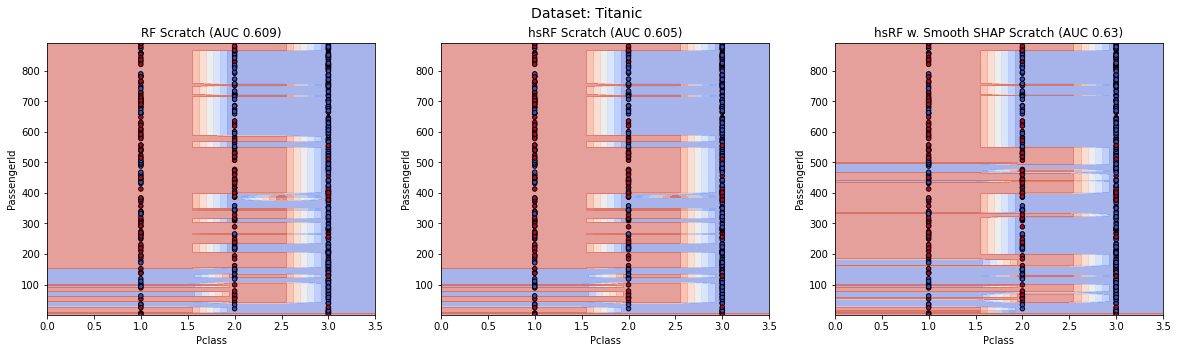

In [25]:
result = create_dec_boun_comparison(X_train, X_test, y_train, y_test, n_estimators=50, reg_params=[0.1,1,10,50,100], random_state=42, 
                                hx=0.1, hy=1, idx_feat1=1, idx_feat2=3)

In [29]:
# Test stored data to recreate plot
X_small = result["data"]["X_small"]
X0 = result["data"]["X0"]
X1 = result["data"]["X1"]
y_train = result["data"]["y_train"]
most_imp_feats_names = result["data"]["most_imp_feats_names"]
rf_scr = result["RF"]["model"]
rf_scr_HS = result["hsRF"]["model"]
rf_scr_HSsmSH = result["hsRFsmSH"]["model"]
auc_rf_scratch = result["RF"]["auc"]
auc_rf_scratch_HS = result["hsRF"]["auc"]
auc_rf_scratch_HSsmSH = result["hsRFsmSH"]["auc"]
cv_resHS = result["hsRF"]["cv_results"]
cv_resHSsmSH = result["hsRFsmSH"]["cv_results"]

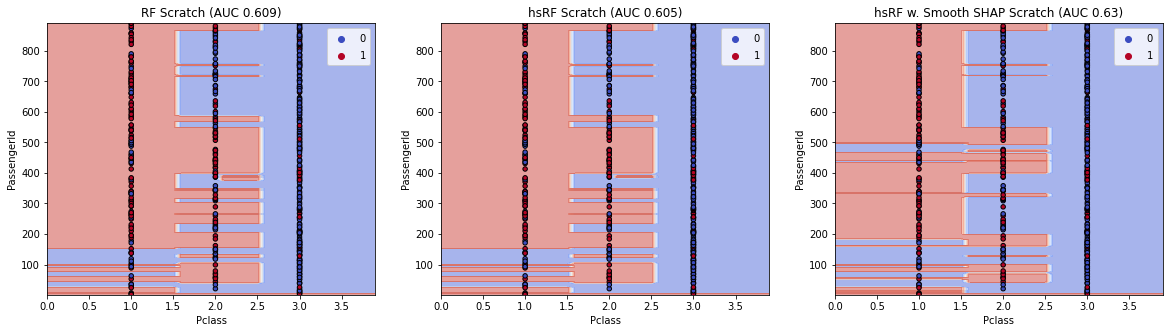

In [42]:
#Create plot
fig, axs = plt.subplots(1,3,figsize=(20,5))
    
# Set-up grid for plotting.
X0, X1 = X_small.iloc[:, 0], X_small.iloc[:, 1]
xx, yy = make_meshgrid(X0, X1, hx=0.1, hy=1)

# Scratch
plot_contours(axs[0], rf_scr, xx, yy, cmap=plt.cm.coolwarm, alpha=0.5)
scatter = axs[0].scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
axs[0].set_ylabel(most_imp_feats_names[1])
axs[0].set_xlabel(most_imp_feats_names[0])
axs[0].set_title(f"RF Scratch (AUC {np.round(auc_rf_scratch,3)})")
axs[0].legend(*scatter.legend_elements())
#print("plot RF complete")

# Scratch with HS
plot_contours(axs[1], rf_scr_HS, xx, yy, cmap=plt.cm.coolwarm, alpha=0.5)
scatter = axs[1].scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
axs[1].set_ylabel(most_imp_feats_names[1])
axs[1].set_xlabel(most_imp_feats_names[0])
axs[1].set_title(f"hsRF Scratch (AUC {np.round(auc_rf_scratch_HS,3)})");
axs[1].legend(*scatter.legend_elements())
#print("plot hsRF complete")

# Scratch with HS
plot_contours(axs[2], rf_scr_HSsmSH, xx, yy, cmap=plt.cm.coolwarm, alpha=0.5)
scatter = axs[2].scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
axs[2].set_ylabel(most_imp_feats_names[1])
axs[2].set_xlabel(most_imp_feats_names[0])
axs[2].set_title(f"hsRF w. Smooth SHAP Scratch (AUC {np.round(auc_rf_scratch_HSsmSH,3)})")
axs[2].legend(*scatter.legend_elements());
#print("plot hsRF w. Smooth SHAP complete")

In [48]:
# Save figure and data
fig.savefig(f"{data_path}/{today_str}_titanic_decbound_plot.png")

# Store results as pickle file
with open(f"{data_path}/{today_str}_titanic_decbound_data.pickle", 'wb') as handle:
    pickle.dump(result, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
print("Lambda hsRF:", cv_resHS["best_param_comb"])
print("Lambda hsRFsmSH:", cv_resHSsmSH["best_param_comb"])
print("Coefficients hsRFsmSH:", rf_scr_HSsmSH.smSHAP_coefs)

Lambda hsRF: (1,)
Lambda hsRFsmSH: (0.1,)
Coefficients hsRFsmSH: [0.9928093663878247, 0.26822785181896164]
